# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import re
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import spacy
from lightgbm import LGBMClassifier
import torch
import transformers

from tqdm.auto import tqdm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

<ipython-input-2-6adc25a4b025>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [5]:
df_reviews = pd.read_csv('/content/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.tail()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164
47330,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,I'll make this brief. This was a joy to watch....,10,pos,1,test,4165


In [8]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [9]:
df_reviews.describe(include='object')

,tconst,title_type,primary_title,original_title,end_year,runtime_minutes,genres,review,sp,ds_part
count,47331,47331,47331,47331,47331,47331,47331,47331,47331,47331
unique,6648,10,6555,6562,60,249,585,47240,2,2
top,tt0067445,movie,The Sentinel,The Sentinel,\N,90,Drama,Loved today's show!!! It was a variety and not...,neg,train
freq,30,36861,60,60,45052,2442,3392,5,23715,23796


In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [11]:
#dropping duplicates
df_reviews[df_reviews.isna().any(axis=1)]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [12]:
df_reviews.dropna(inplace=True)

In [13]:
df_reviews.drop_duplicates(subset=df_reviews.columns.difference(['idx']), inplace=True)

In [14]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47244 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47244 non-null  object 
 1   title_type       47244 non-null  object 
 2   primary_title    47244 non-null  object 
 3   original_title   47244 non-null  object 
 4   start_year       47244 non-null  int64  
 5   end_year         47244 non-null  object 
 6   runtime_minutes  47244 non-null  object 
 7   is_adult         47244 non-null  int64  
 8   genres           47244 non-null  object 
 9   average_rating   47244 non-null  float64
 10  votes            47244 non-null  Int64  
 11  review           47244 non-null  object 
 12  rating           47244 non-null  int64  
 13  sp               47244 non-null  object 
 14  pos              47244 non-null  int64  
 15  ds_part          47244 non-null  object 
 16  idx              47244 non-null  int64  
dtypes: Int64(1), floa

2 rows containing NA values were found and dropped, as well as 87 duplicate entries. These dropped rows comprised 0.00188 of the full original dataset.

## EDA

Let's check the number of movies and reviews over years.

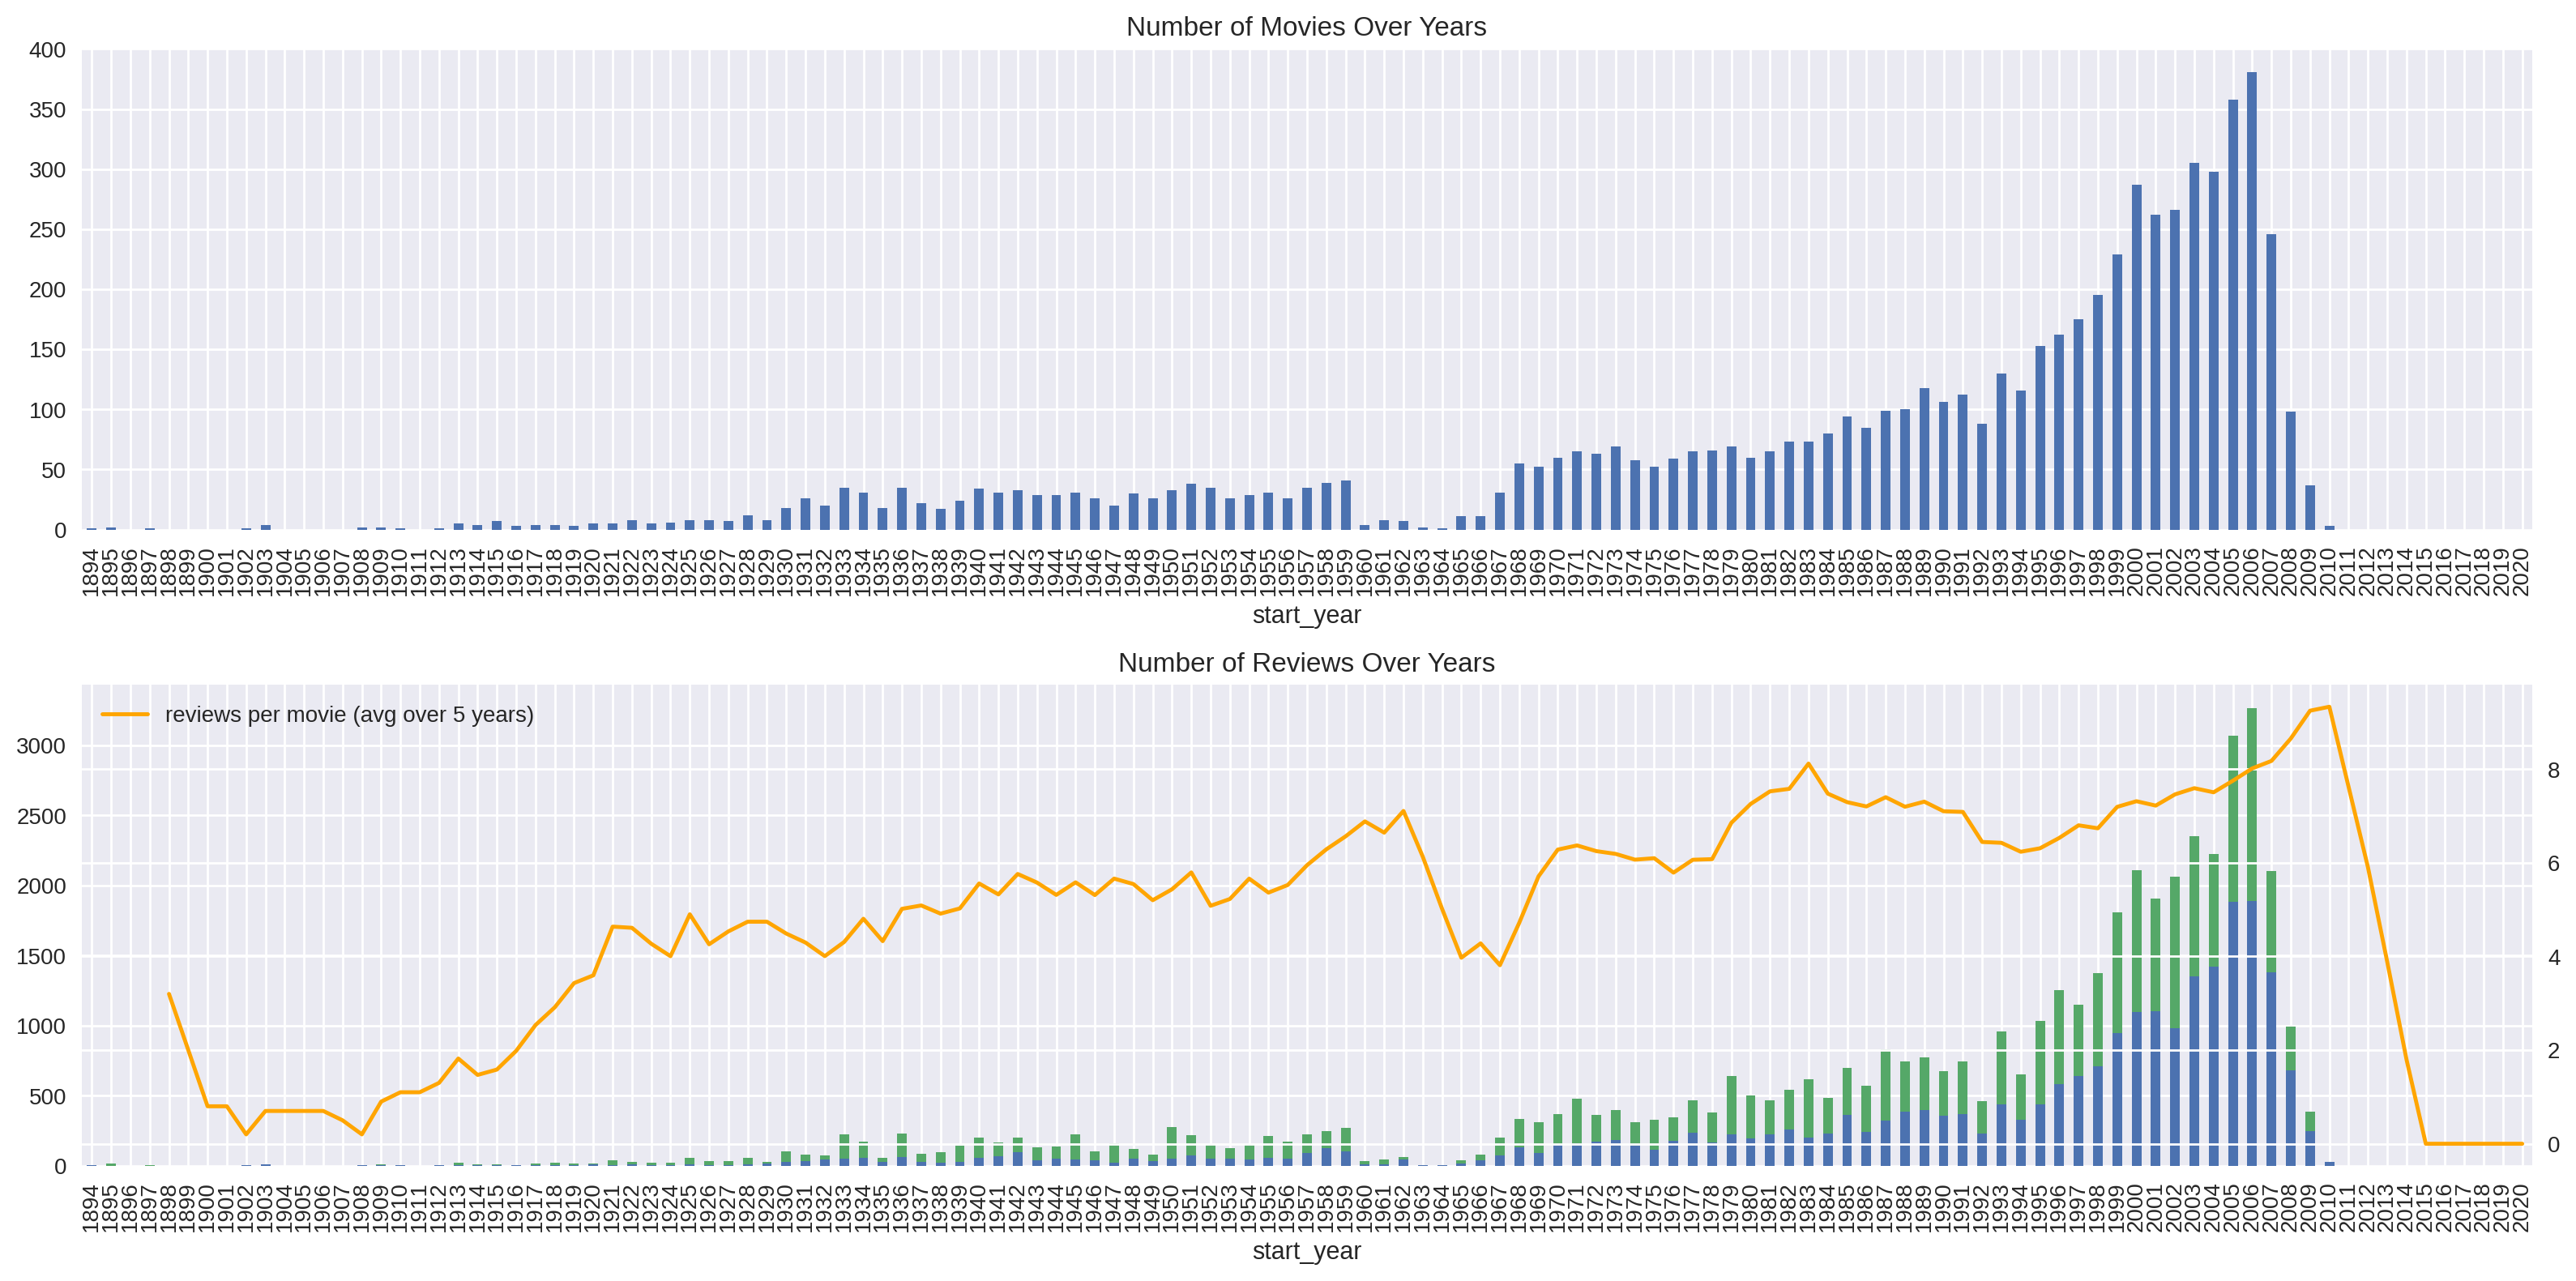

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Both the total number of movies and total number of reviews in the dataset generally increases per year.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

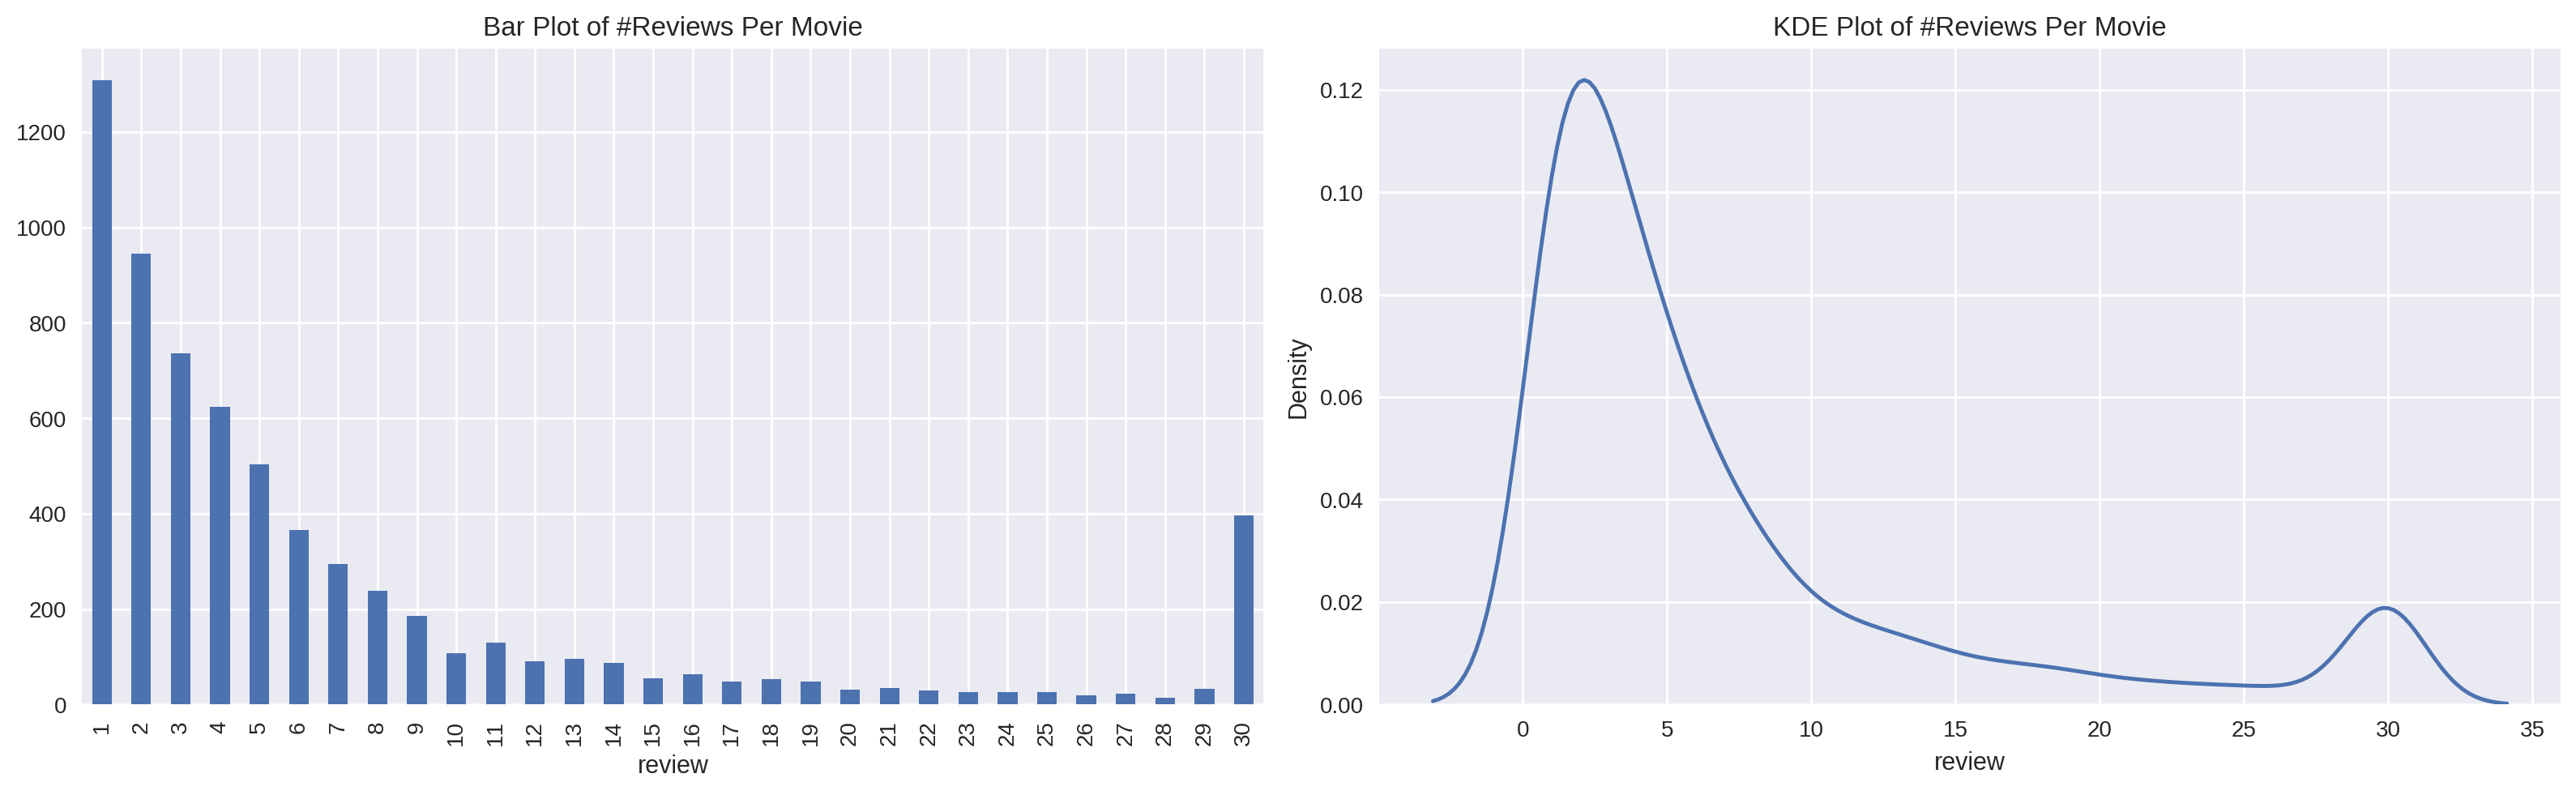

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Most of the movies in the dataset have a low number of reveiws.

In [17]:
df_reviews['pos'].value_counts()

,count
pos,
0,23682
1,23562


In [18]:
print(((df_reviews['ds_part'] == "train") & (df_reviews['pos']==0)).sum())
print(((df_reviews['ds_part'] == "train") & (df_reviews['pos']==1)).sum())

11896
11864


In [19]:
print(((df_reviews['ds_part'] == "test") & (df_reviews['pos']==0)).sum())
print(((df_reviews['ds_part'] == "test") & (df_reviews['pos']==1)).sum())

11786
11698


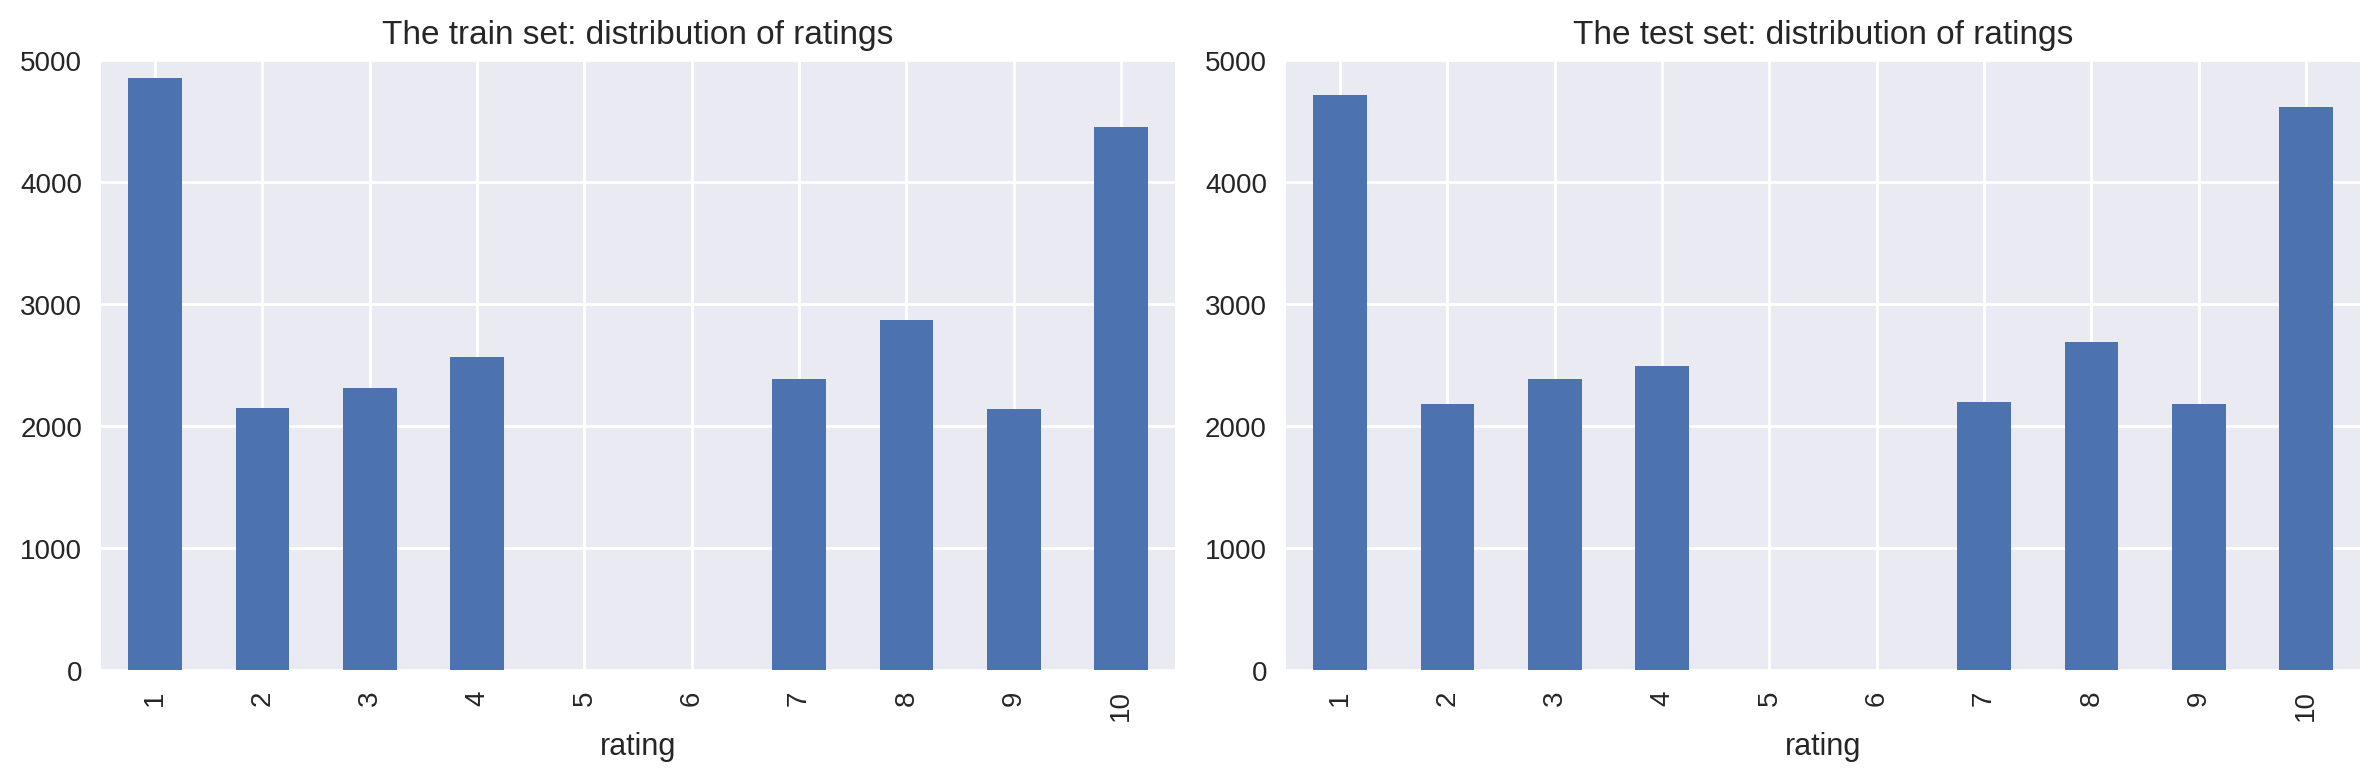

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution of ratings between the train test and the test set are similar.

Distribution of negative and positive reviews over the years for two parts of the dataset

<ipython-input-21-e0e81b3a9b29>:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-21-e0e81b3a9b29>:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
<ipython-input-21-e0e81b3a9b29>:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-21-e0e81b3a9b29>:31: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

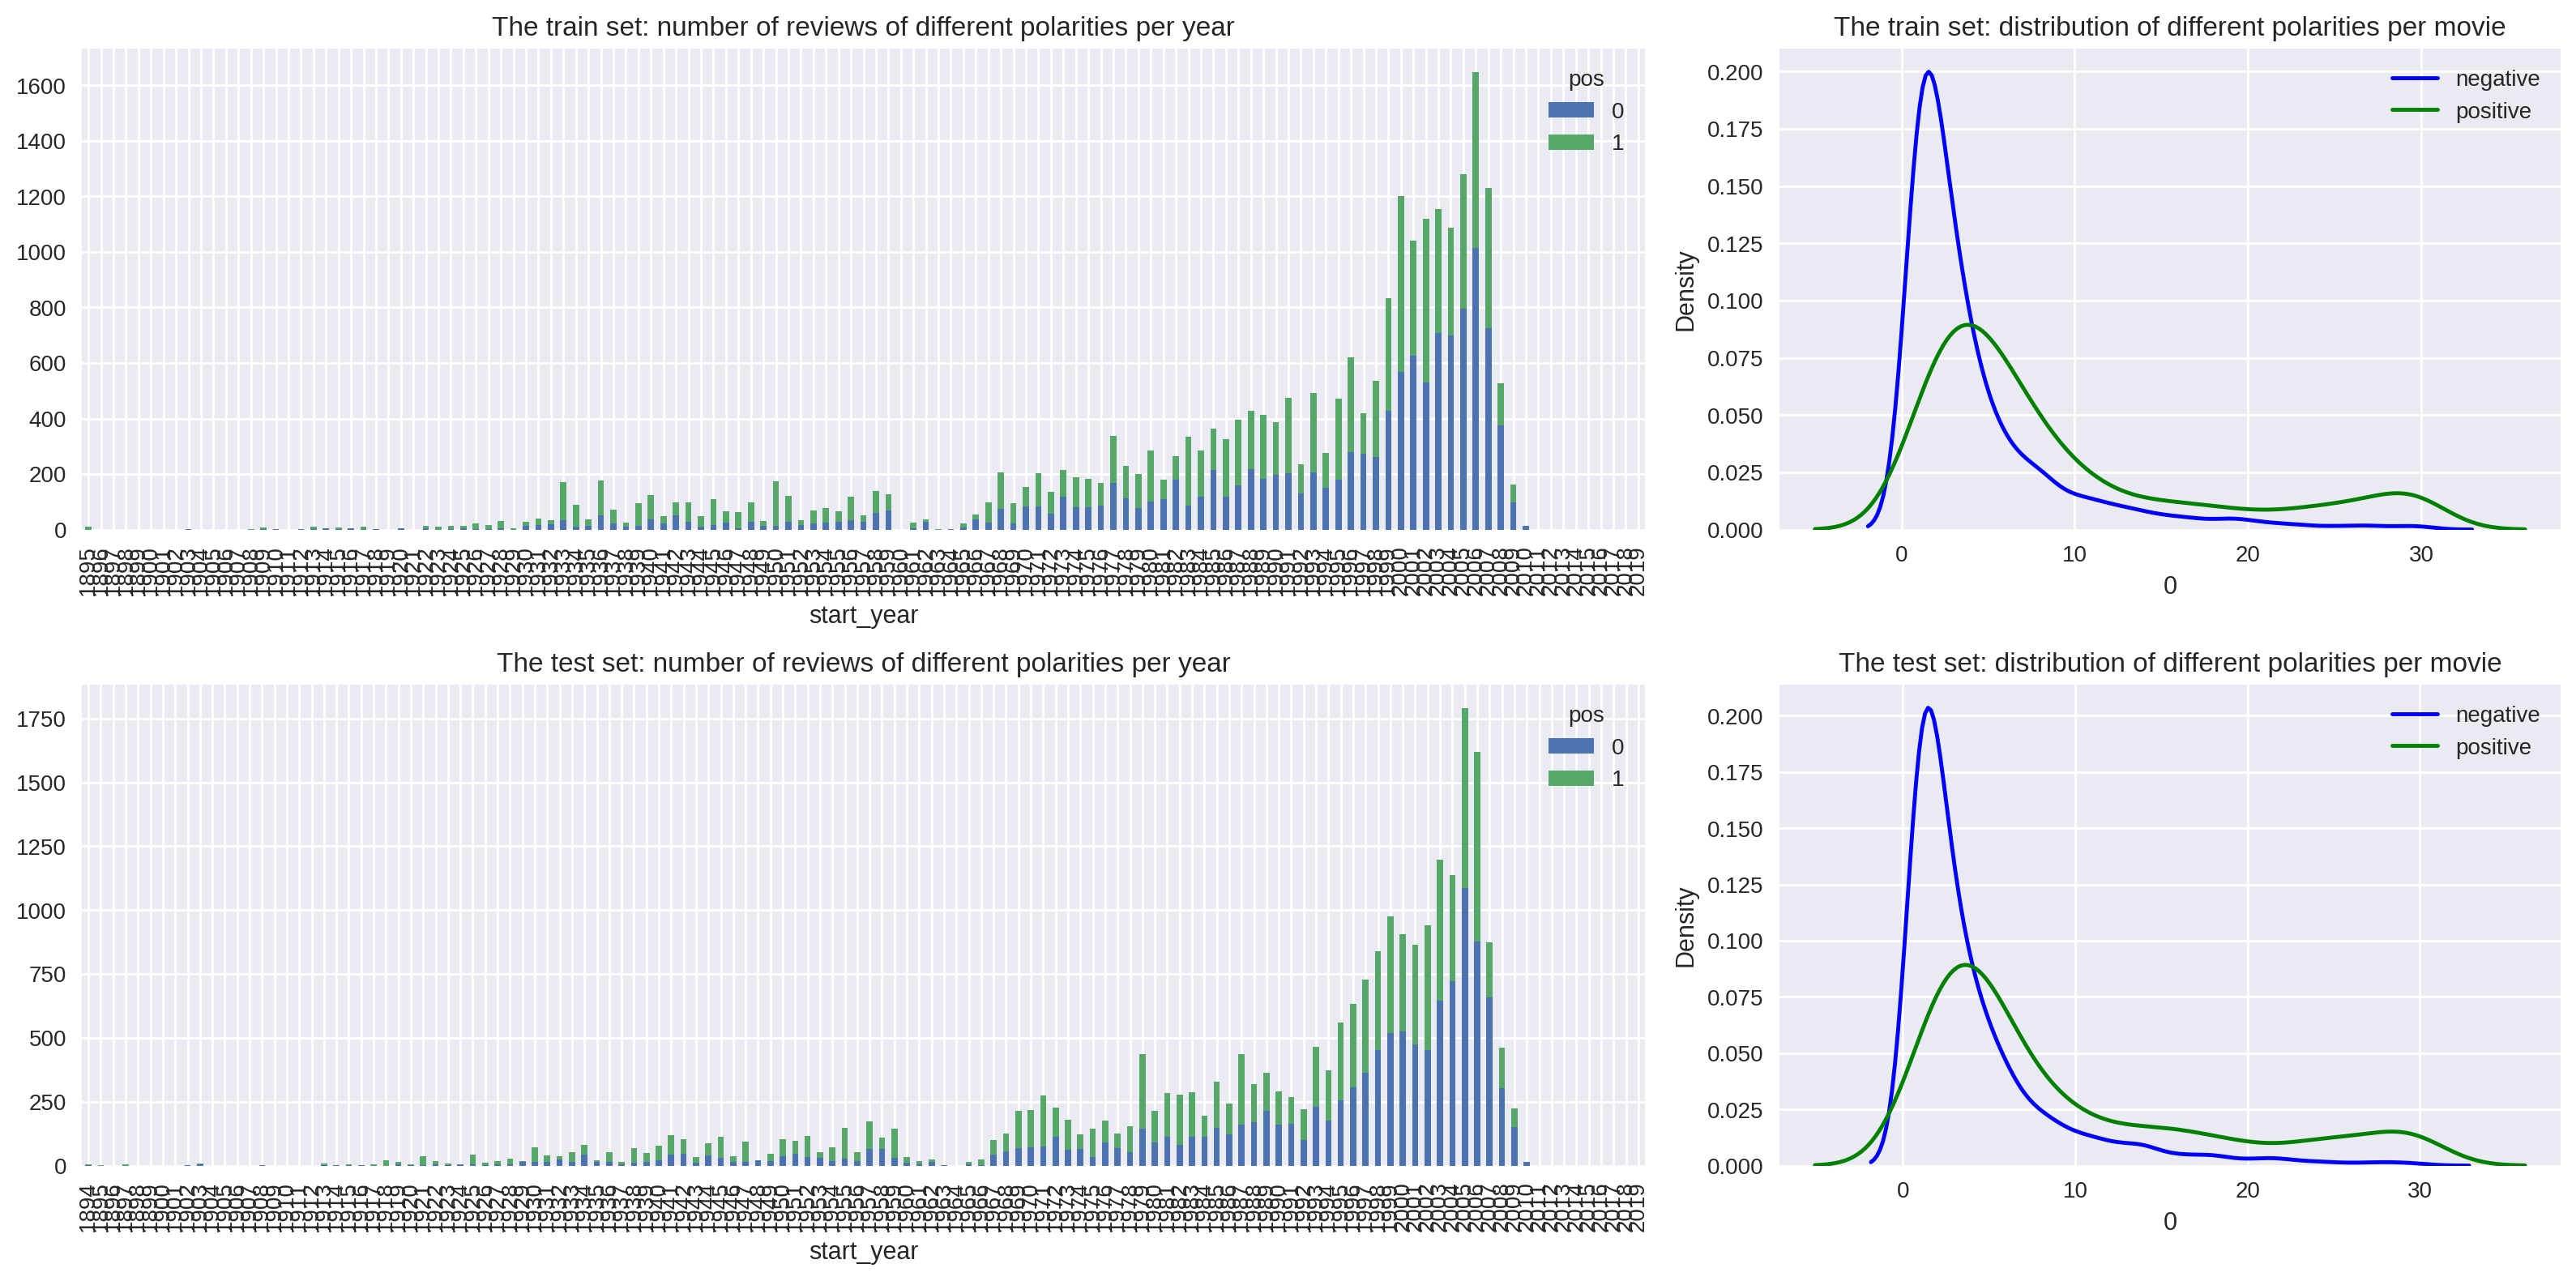

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

After reviewing the resulting graphs, it was observed that both the total number of movies and the total number of reviews in the dataset generally increase each year. The majority of movies in the dataset have a relatively low number of reviews.

There is no significant class imbalance; the number of positive and negative reviews across the dataset is nearly equal. The distribution of ratings between the training set and the test set is comparable. Similarly, the distribution of positive and negative reviews is consistent between the training set and the test set.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [22]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [23]:
def normalize_text(text):
    normalized_text = re.sub(r"[^a-zA-Z']", " ", text).split()
    normalized_text = ' '.join(normalized_text).lower()
    return normalized_text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

In [24]:
df_reviews['review_norm'].head()

,review_norm
0,the pakage implies that warren beatty and gold...
1,how the hell did they get this made presenting...
2,there is no real story the film seems more lik...
3,um a serious film about troubled teens in sing...
4,i'm totally agree with garryjohal from singapo...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [25]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

train_features = df_reviews_train['review_norm']
test_features = df_reviews_test ['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23760, 18)
(23484, 18)


## Working with models

### Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


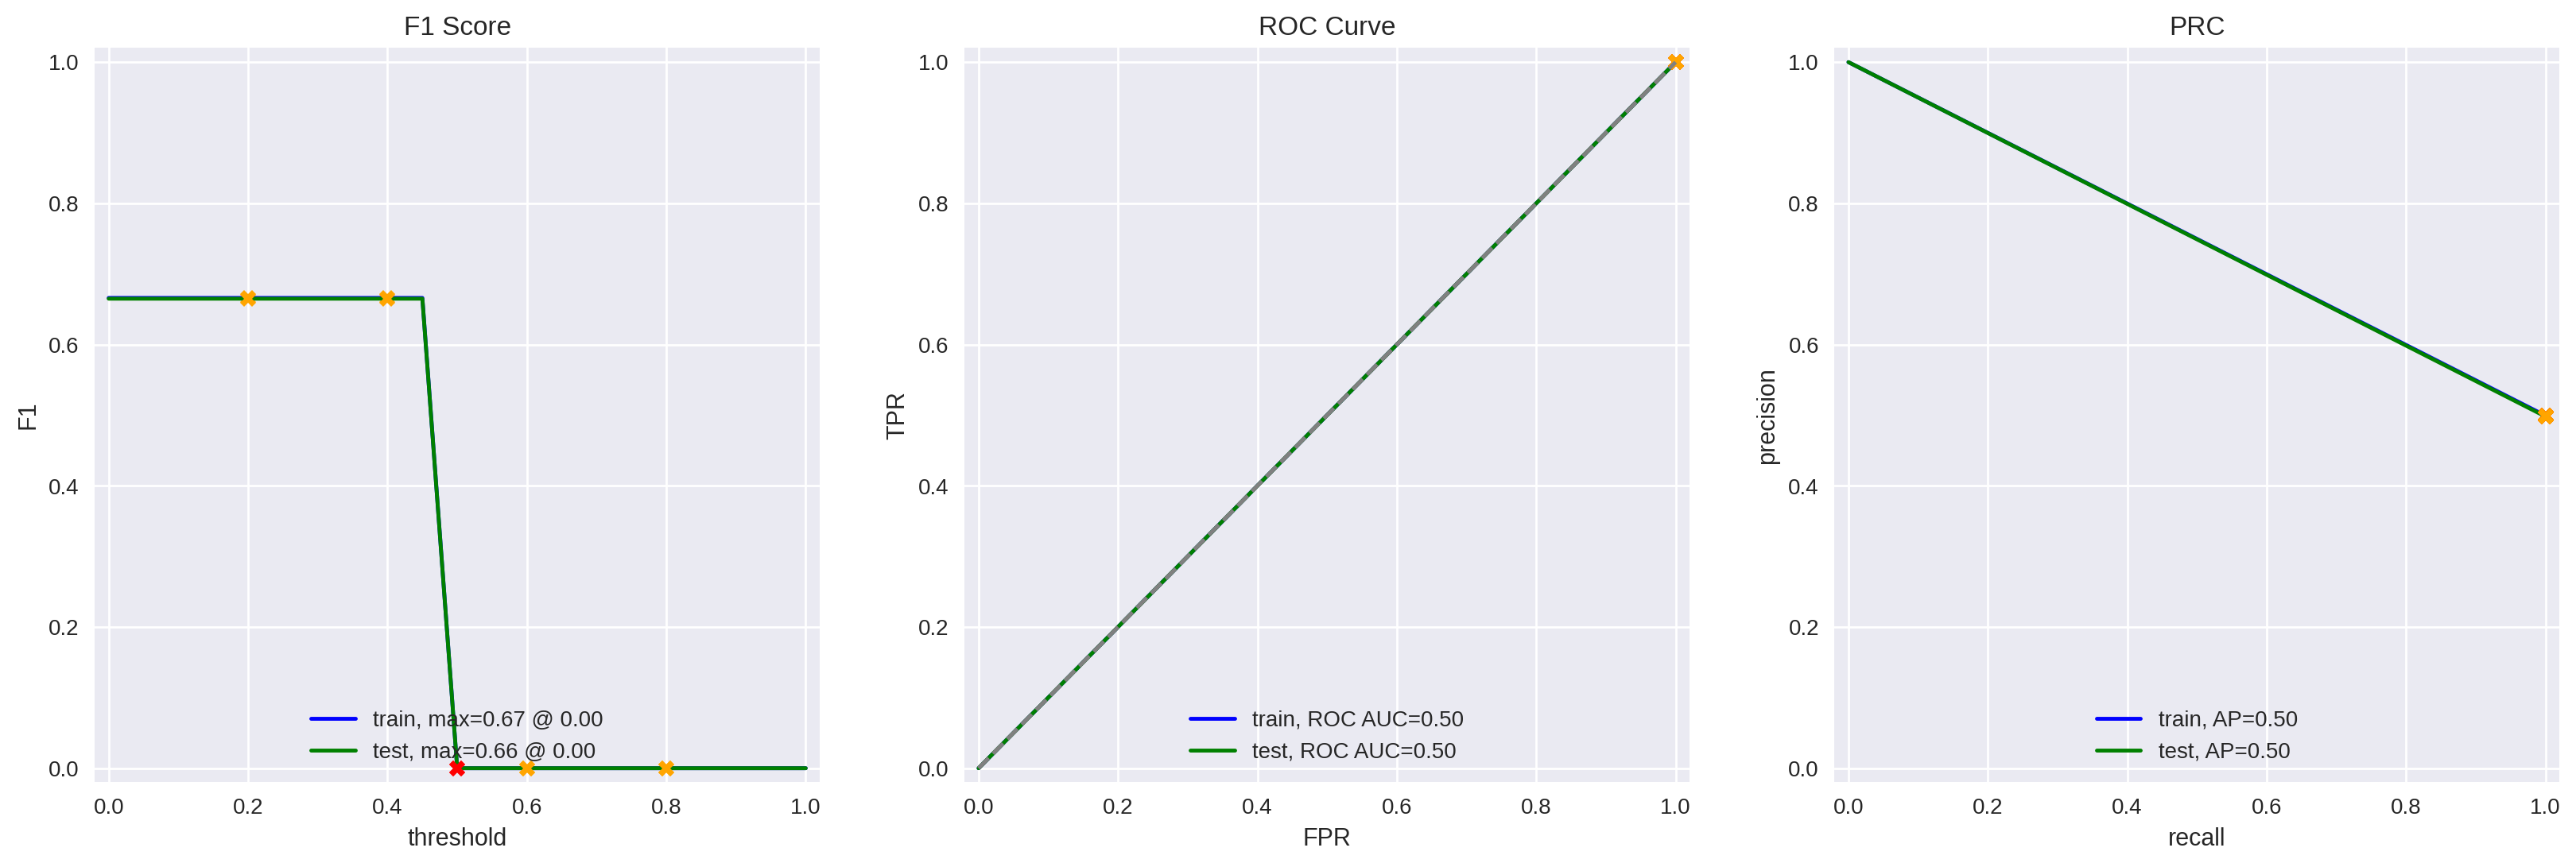

In [26]:
dummy = DummyClassifier(random_state=12345)
dummy.fit(train_features, train_target)

evaluate_model(dummy, train_features, train_target, test_features, test_target)

### Conclusion:

The constant model, as expected, performs no better than random guessing, with all key metrics (Accuracy, F1, ROC AUC, and APS) reflecting a baseline level of 0.5 or 0.0. The plots confirm this, showing no meaningful classification ability, reinforcing the need for a more sophisticated model to achieve better performance.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
print(type(train_features))
print(train_features[:5])  # Check the first 5 entries

<class 'pandas.core.series.Series'>
0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
7    this true story of carlson's raiders is more o...
8    should have been titled 'balderdash ' little i...
9    the movie 'gung ho ' the story of carlson's ma...
Name: review_norm, dtype: object


In [36]:
train_features = [str(doc) for doc in train_features]

In [38]:
train_features = [doc for doc in train_features if isinstance(doc, str) and doc.strip()]

In [42]:
stop_words = list(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

train_features_1 = count_tf_idf.fit_transform(train_features)
test_features_1 = count_tf_idf.transform(test_features)

In [43]:
model_1 = LogisticRegression(random_state=12345)
model_1.fit(train_features_1, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


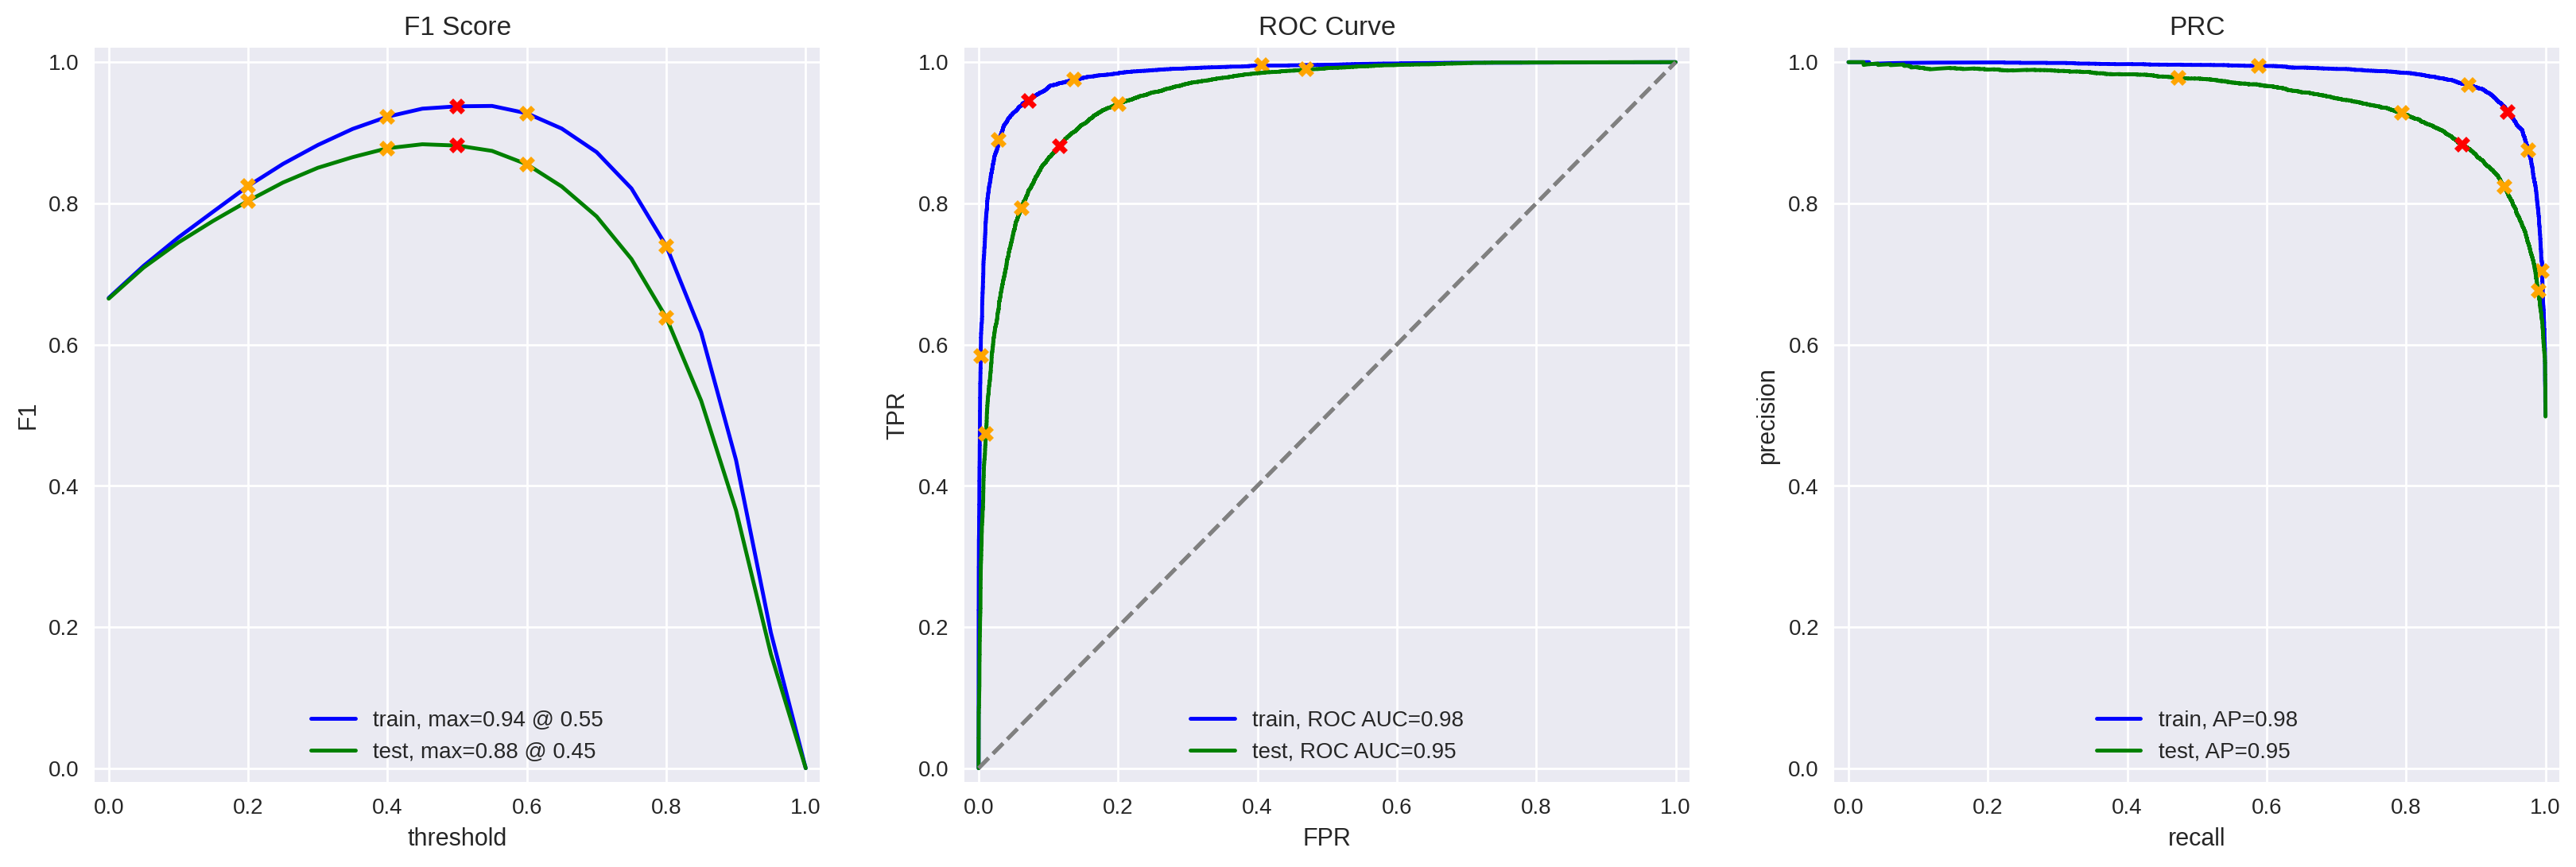

In [44]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Conclusion:

The model (`model_1`) demonstrates strong performance on both the training and test sets, with high accuracy (0.94 on train, 0.88 on test) and robust F1 scores (0.94 on train, 0.88 on test). The ROC AUC values (0.98 on train, 0.95 on test) and APS (0.98 on train, 0.95 on test) indicate that the model has excellent discriminatory ability and precision across different thresholds. The plots confirm consistent performance between the training and test sets, suggesting that the model generalizes well without significant overfitting.

### Model 2- spaCy, TF-IDF and LR

In [45]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#Obtain set of stopwords from spacy.
stop_words = nlp.Defaults.stop_words

In [46]:
def text_preprocessing_3(text):

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)

In [49]:
train_features = pd.Series(train_features)

In [50]:
#Lemmatize reviews in training and testing datasets.
train_lem_spacy = train_features.progress_apply(text_preprocessing_3)
test_lem_spacy = test_features.progress_apply(text_preprocessing_3)

  0%|          | 0/23760 [00:00<?, ?it/s]

  0%|          | 0/23484 [00:00<?, ?it/s]

In [52]:
stop_words = list(stopwords.words('english'))
count_tf_idf_2 = TfidfVectorizer(stop_words=stop_words)

train_features_2 = count_tf_idf_2.fit_transform(train_lem_spacy)
test_features_2 = count_tf_idf_2.transform(test_lem_spacy)

In [53]:
model_2 = LogisticRegression(random_state=12345)
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


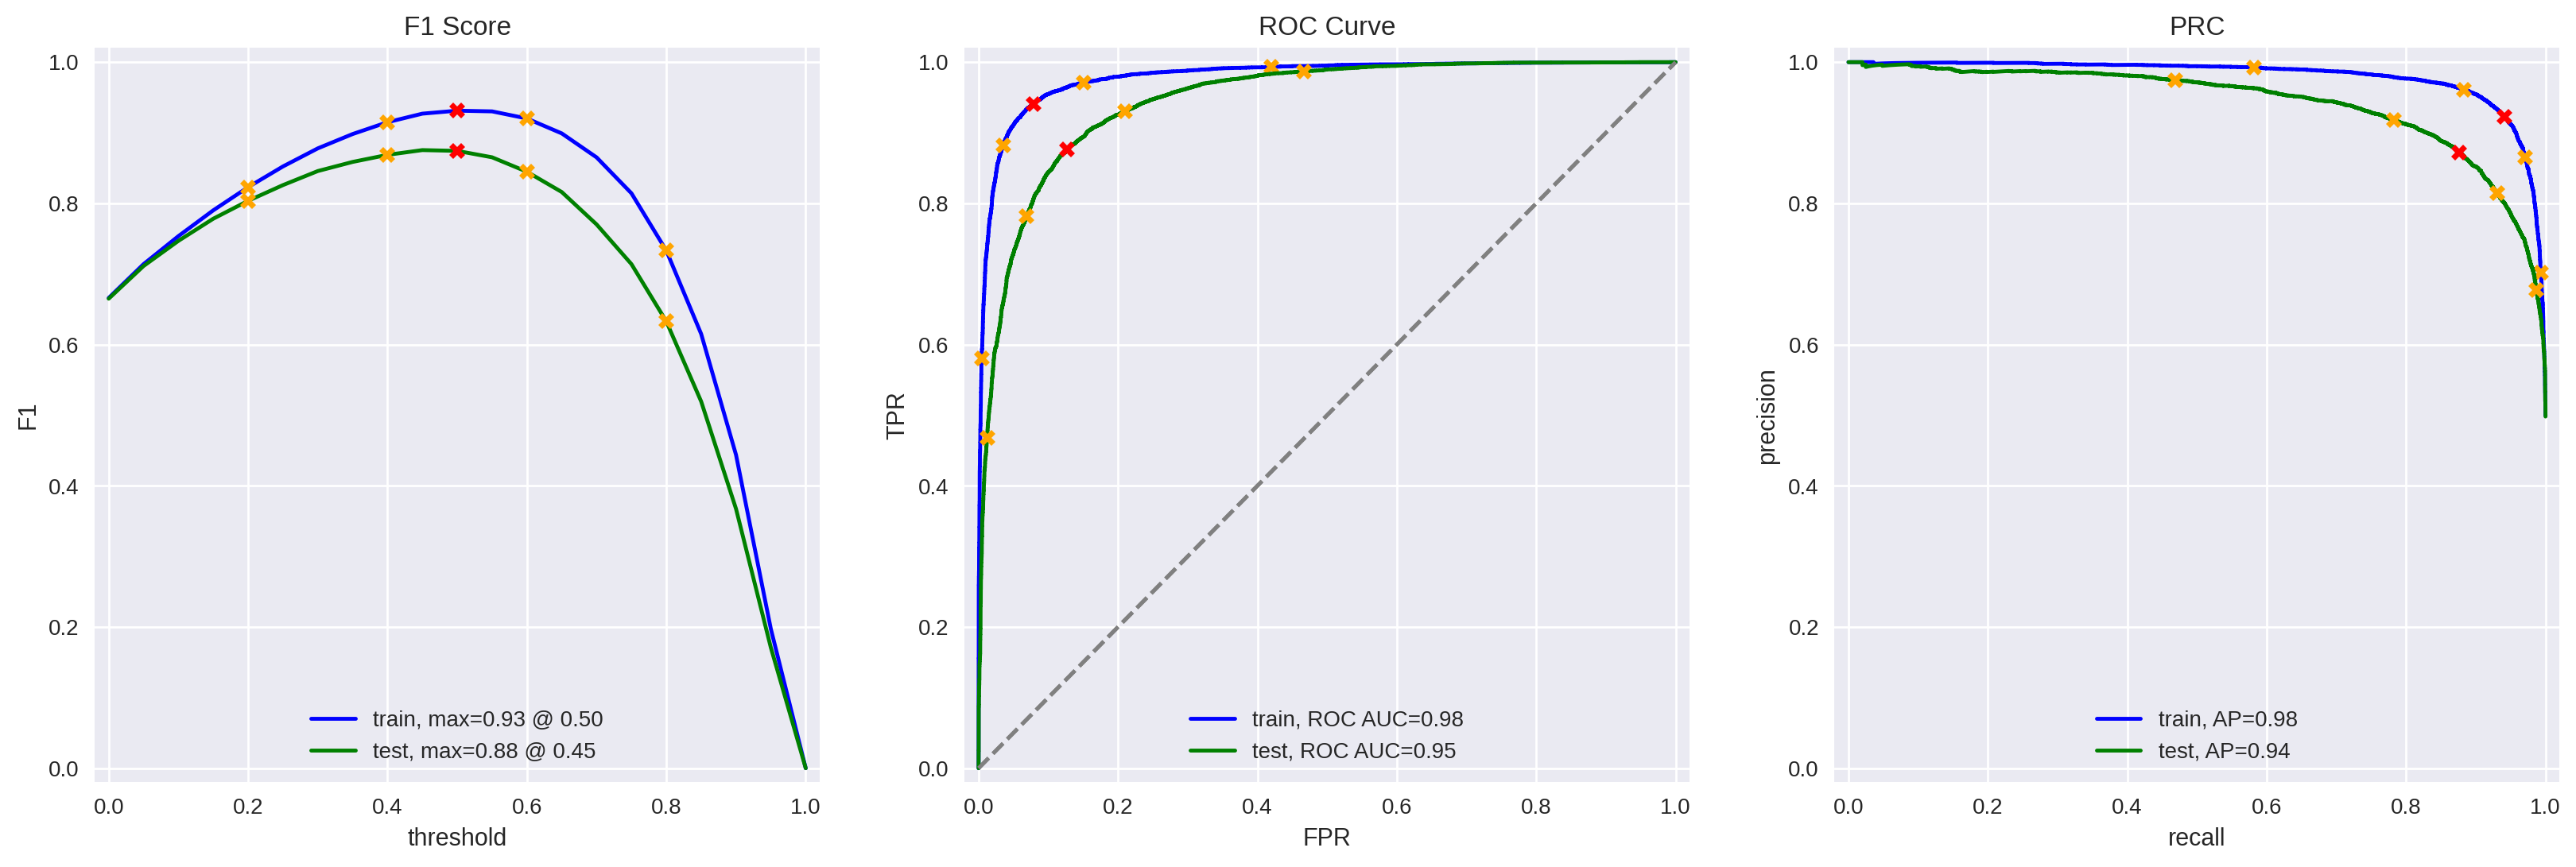

In [54]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Conclusion:

Model 2 exhibits strong and consistent performance across both the training and test sets. The accuracy and F1 scores (0.93 and 0.87, respectively) indicate that the model performs well in both classification accuracy and balancing precision and recall. The high ROC AUC values (0.98 on train, 0.95 on test) demonstrate excellent discriminatory power, and the APS (0.98 on train, 0.94 on test) confirms the model's ability to predict positive instances effectively. The close alignment between the training and test metrics suggests that the model generalizes well without significant overfitting, similar to Model 1.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [55]:
model_3 = LGBMClassifier(random_state=12345)
model_3.fit(train_features_2, train_target)

[LightGBM] [Info] Number of positive: 11864, number of negative: 11896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.052065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430484
[LightGBM] [Info] Number of data points in the train set: 23760, number of used features: 9231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499327 -> initscore=-0.002694
[LightGBM] [Info] Start training from score -0.002694


LGBMClassifier(random_state=12345)

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


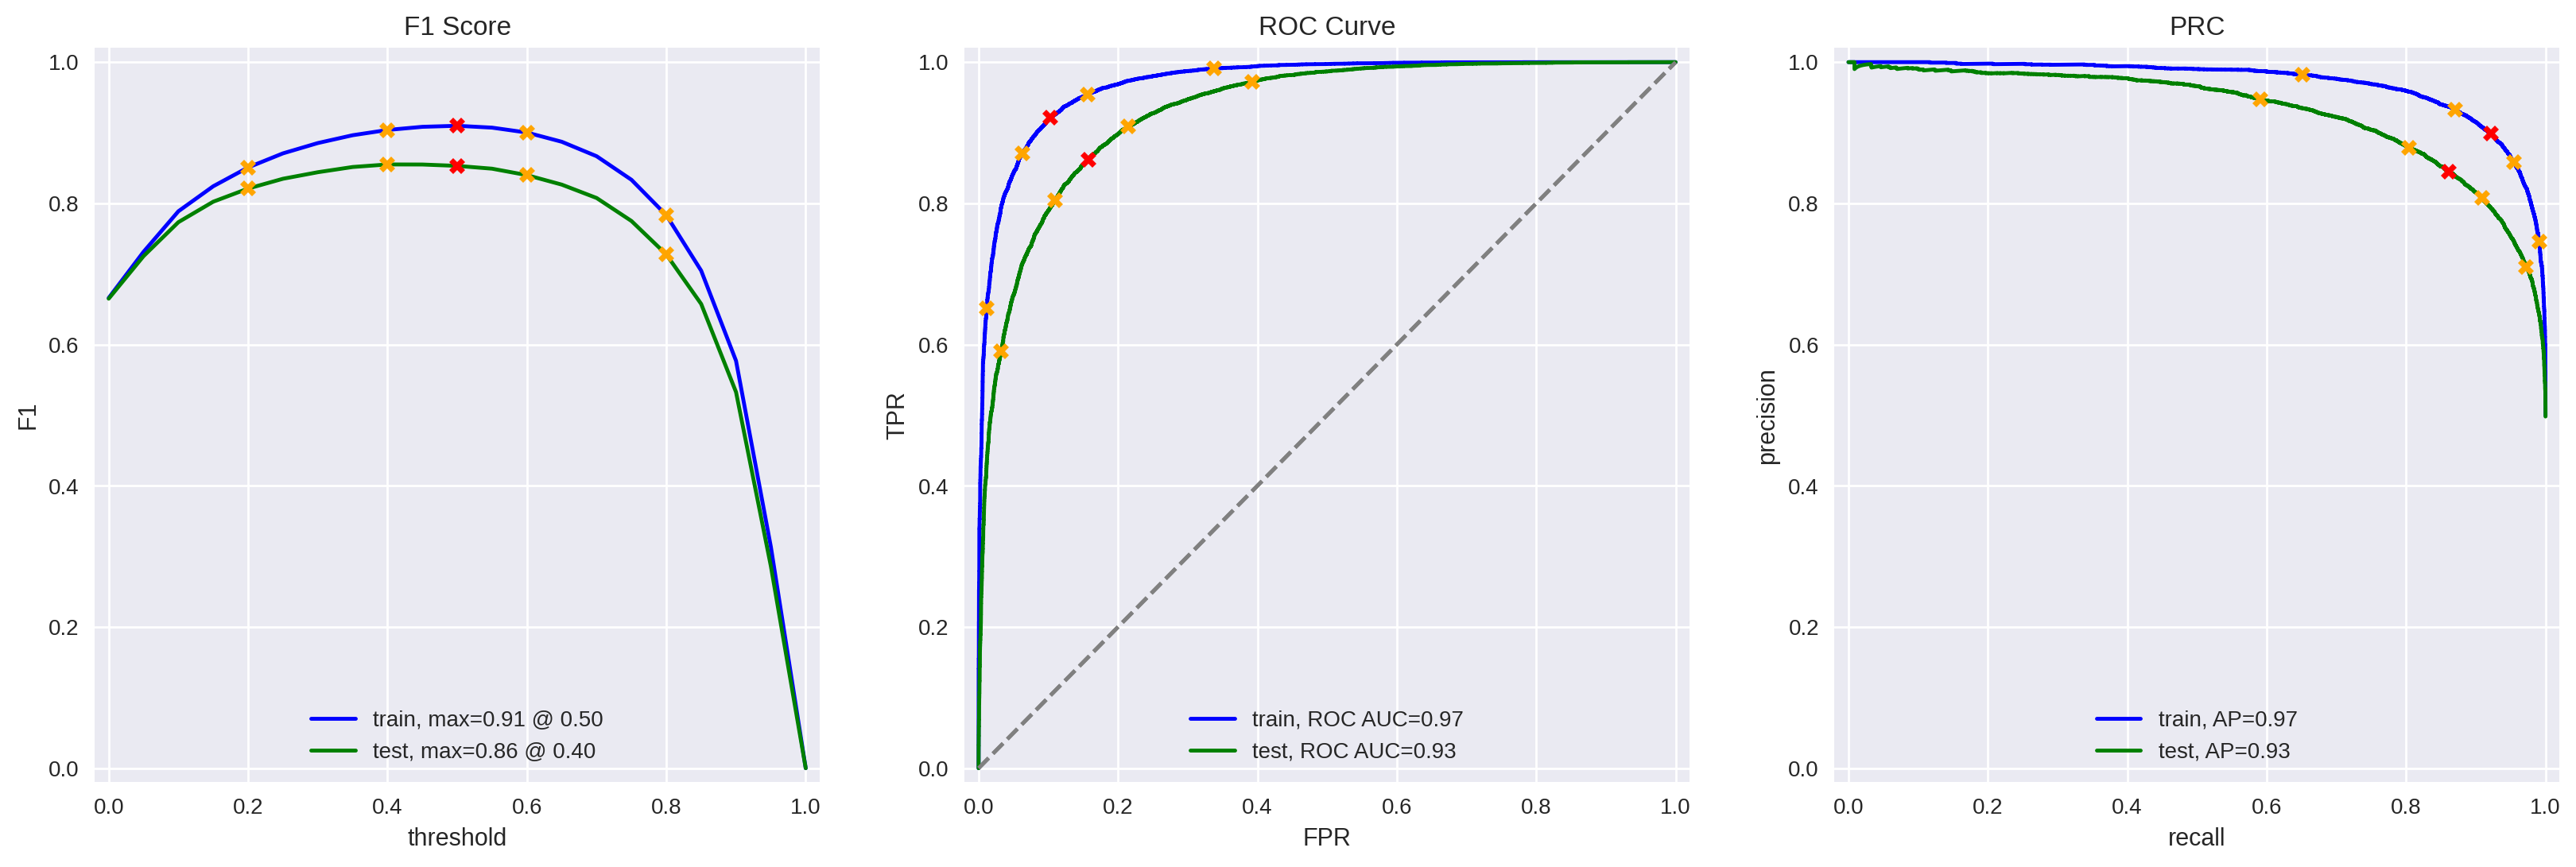

In [56]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)


<div class="alert alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Reviewer's comment </b>
    
Please add a conclusion :) 
    
</div>

### Conclusion:

Model 3 shows strong performance with slightly lower metrics compared to Models 1 and 2. The accuracy (0.91 on train, 0.85 on test) and F1 scores (0.91 on train, 0.85 on test) indicate that the model performs well but has a small drop in performance on the test set. The ROC AUC values (0.97 on train, 0.93 on test) and APS (0.97 on train, 0.93 on test) are still high, showing good discriminatory power and precision. However, the slightly lower metrics suggest that this model might not generalize as well as the previous models, indicating a potential for mild overfitting or that the model may require further tuning for optimal performance on unseen data.

###  Model 4 - BERT

In [57]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [89]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=8, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks

    for input_text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0] * (max_length-len(ids)))
        attention_mask = np.where(padded != 0,1,0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [90]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_4 = BERT_text_to_embeddings(df_reviews_train['review_norm'].sample(n=100, random_state=12345), force_device='cpu')

  0%|          | 0/100 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/13 [00:00<?, ?it/s]

<ipython-input-89-884fc7a804a7>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [91]:
train_target_4 = train_target.sample(n=100, random_state=12345)

In [93]:
print(df_reviews_train['review_norm'].shape)
print(train_features_4.shape)
print(train_target_4.shape)

(23796,)
(100, 768)
(100,)


In [95]:
test_target_4 = test_target.sample(n=100, random_state=12345)

In [94]:
test_features_4 = BERT_text_to_embeddings(df_reviews_test['review_norm'].sample(n=100, random_state=12345), force_device='cpu')

  0%|          | 0/100 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/13 [00:00<?, ?it/s]

In [96]:
print(df_reviews_test['review_norm'].shape)
print(test_features_4.shape)
print(test_target_4.shape)

(23535,)
(100, 768)
(100,)


In [97]:
model_4 = LogisticRegression(random_state=12345)
model_4.fit(train_features_4, train_target_4)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=12345)

          train  test
Accuracy    1.0  0.72
F1          1.0  0.71
APS         1.0  0.81
ROC AUC     1.0  0.82


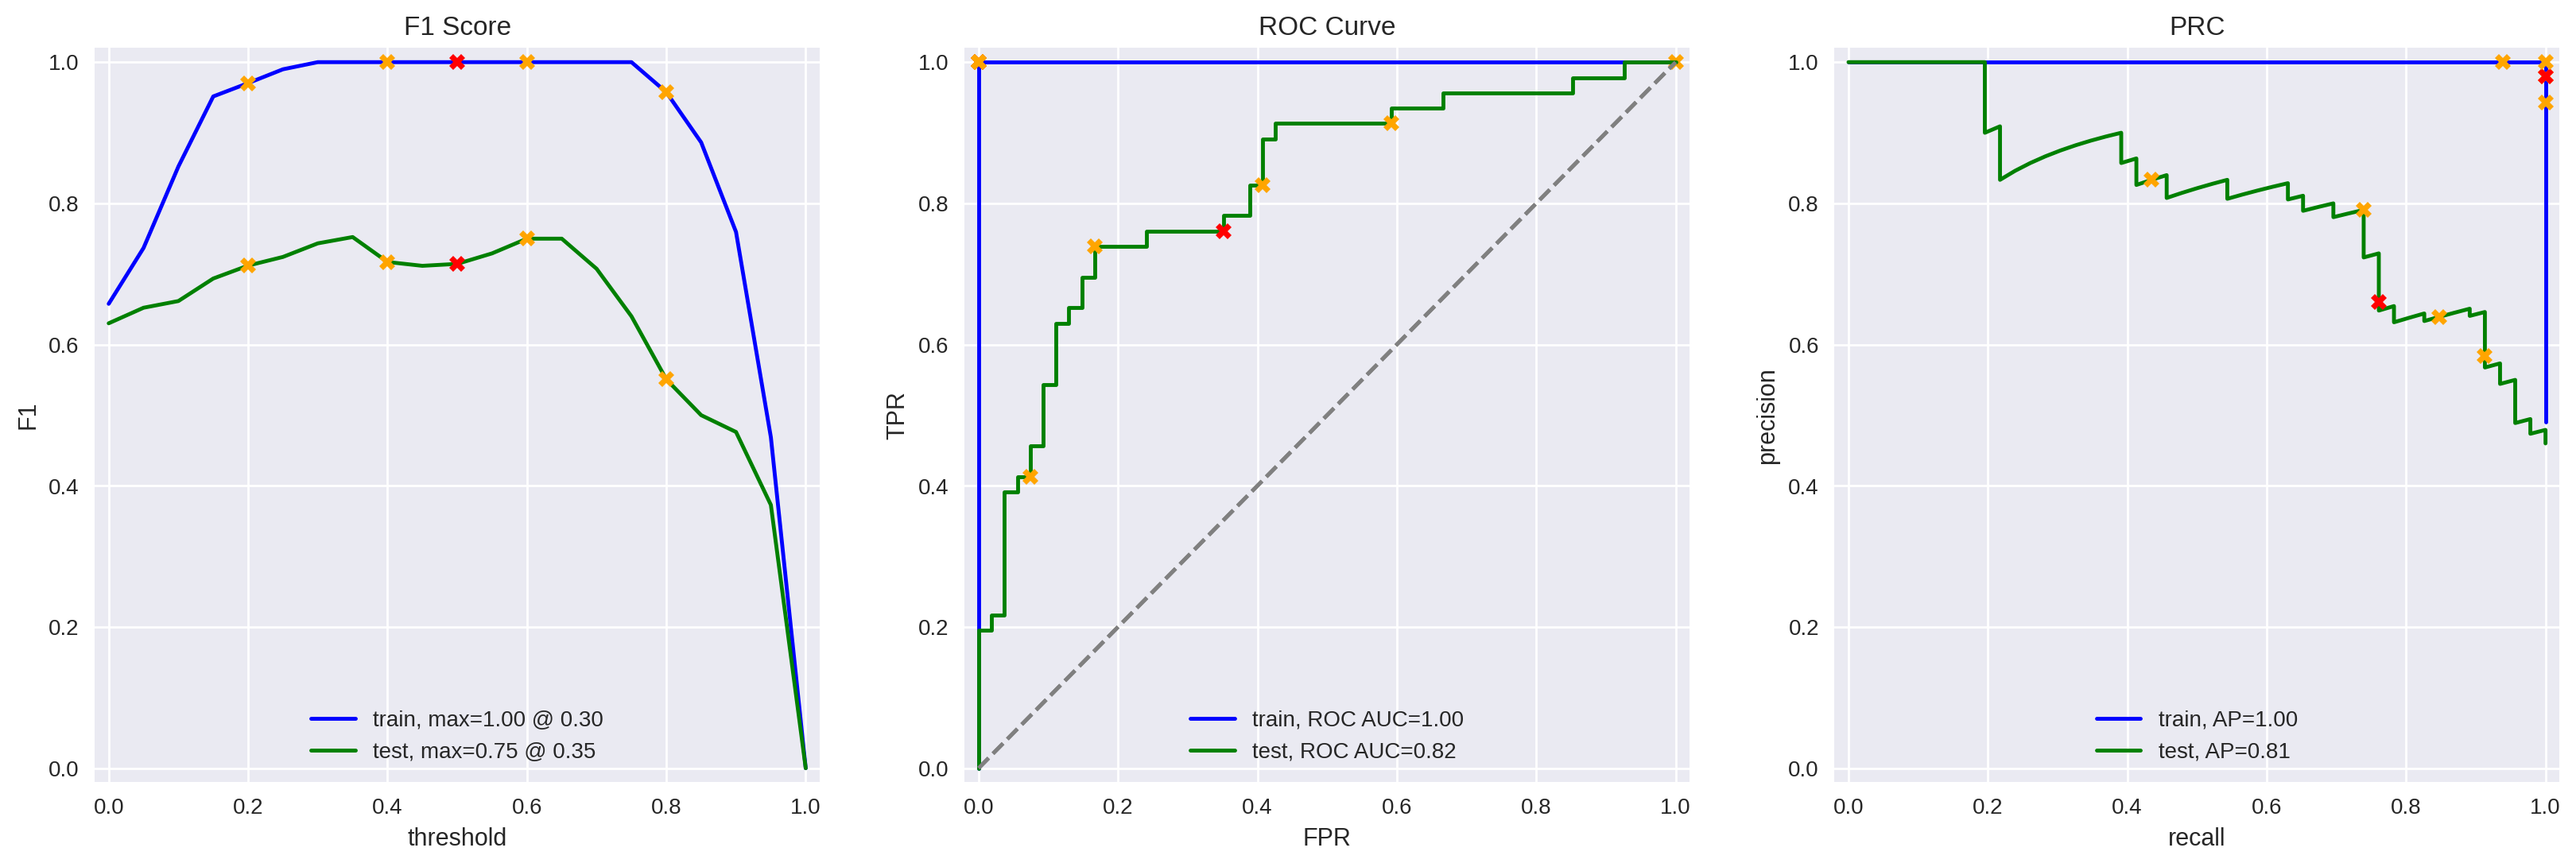

In [98]:
evaluate_model(model_4, train_features_4, train_target_4, test_features_4, test_target_4)

In [99]:
# if you have got the embeddings, it's advisable to save them to have them ready if
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [110]:
model_4 = LogisticRegression(random_state=12345)
model_4.fit(train_features_4, train_target_4)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=12345)

          train  test
Accuracy    1.0  0.72
F1          1.0  0.71
APS         1.0  0.81
ROC AUC     1.0  0.82


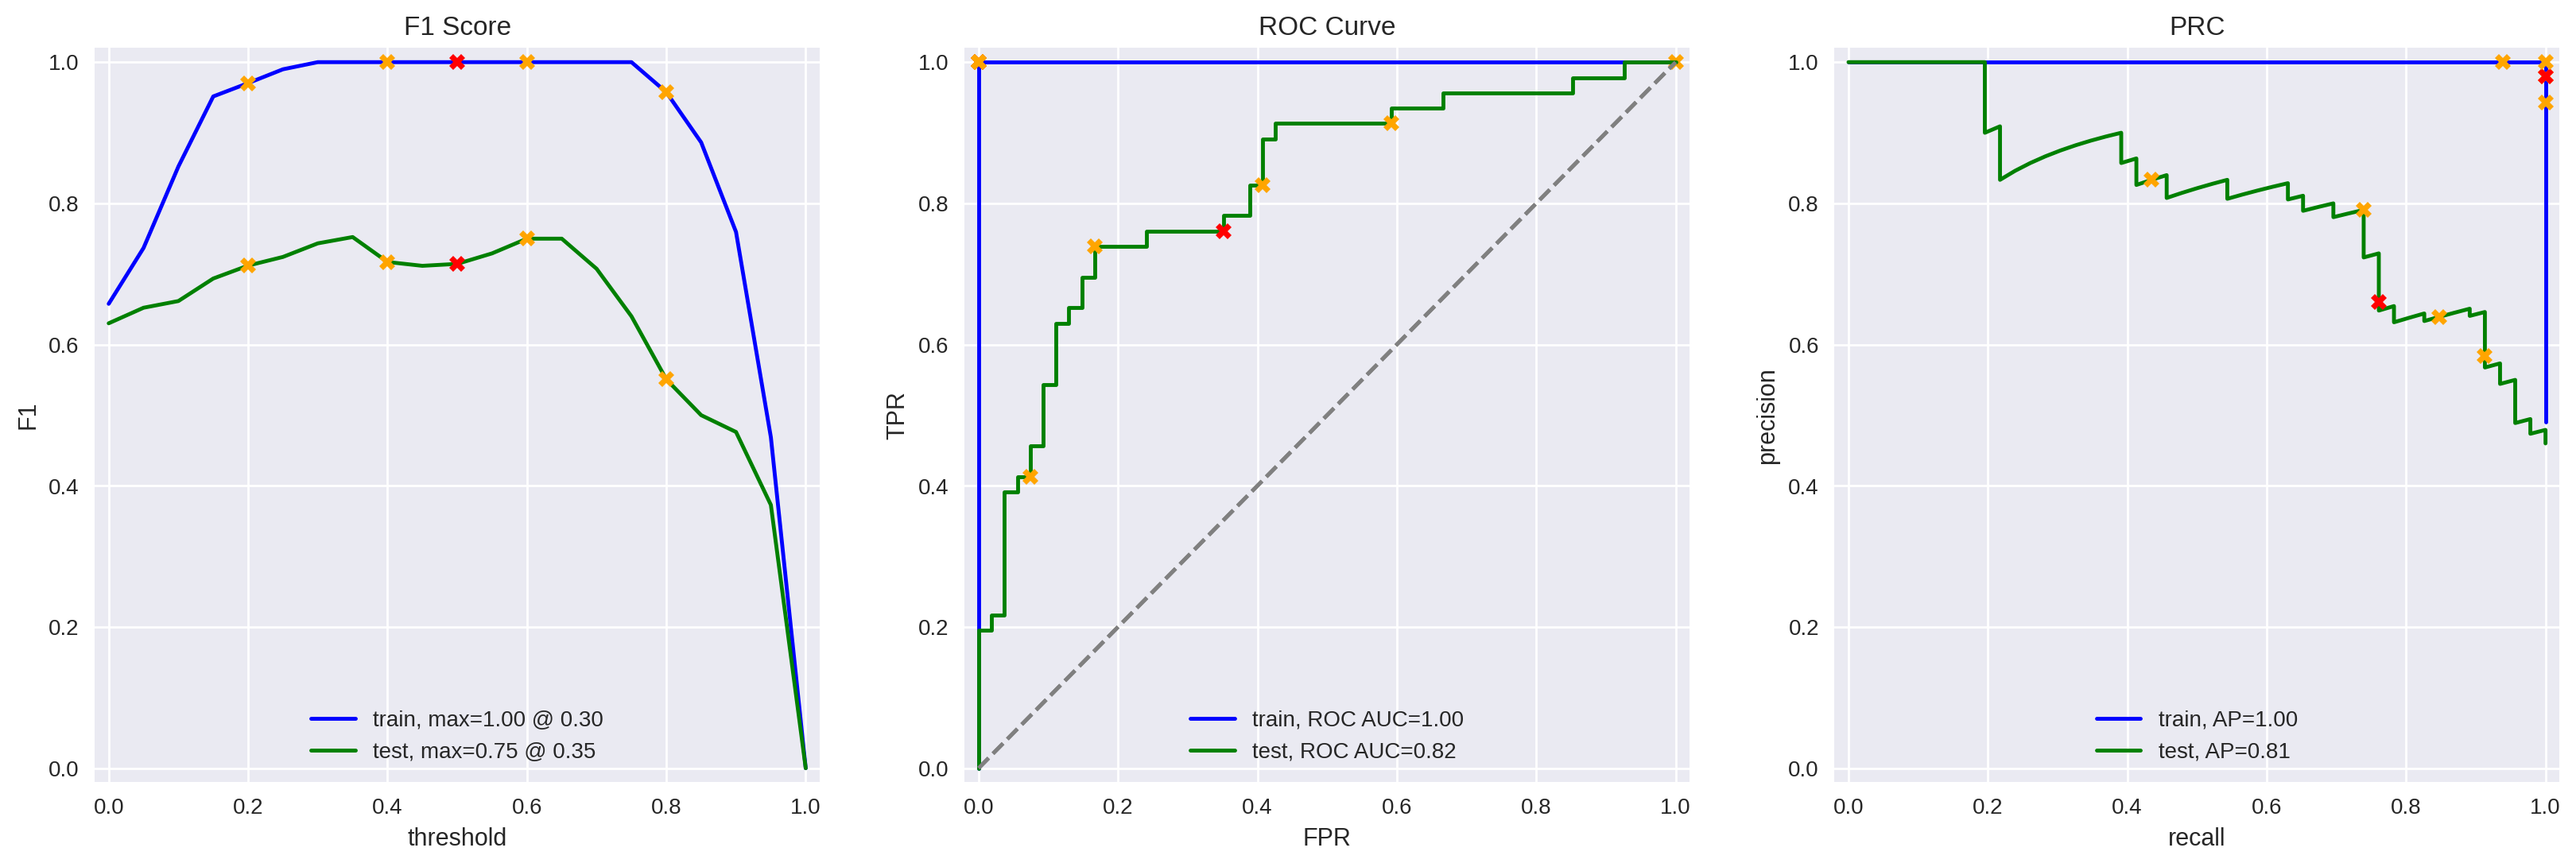

In [112]:
#Evaluate model.
evaluate_model(model_4, train_features_4, train_target_4, test_features_4, test_target_4)

### Conclusion:

Model 4 appears to be highly overfitted to the training data. The perfect scores on the training set (Accuracy, F1, APS, and ROC AUC all at 1.0) indicate that the model has learned the training data very well, likely memorizing it. However, the performance on the test set is significantly lower (Accuracy: 0.72, F1: 0.71, APS: 0.81, and ROC AUC: 0.82), suggesting that the model struggles to generalize to unseen data.

The sharp decline in the F1 score and ROC AUC on the test set, along with the visibly different curves between the train and test plots, confirm that the model has overfit the training data. This indicates that the model is too complex or not regularized enough, and may require adjustments such as simplifying the model, adding regularization, or employing techniques like cross-validation to improve its generalization ability.

## My Reviews

In [102]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 1

In [113]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.53:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 2

In [114]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didn't expect the reboot to be so good writers really cared about the source material
0.39:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [115]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  i did not simply like it not my kind of movie
0.34:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.37:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.64:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.29:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.76:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [116]:
ttexts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  i did not simply like it not my kind of movie
0.34:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.37:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.64:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.29:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.76:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

4 models were examined:

NLTK, TF-IDF and LR
spaCy, TF-IDF and LR
spaCy, TF-IDF and LGBMClassifier
BERT and LR
All models showed an improvement when compared to the dummy model.

After comparing the F1 scores and the classification results of the reviews in "My Reviews", the models that utilized TF-IDF and LR together performed the best with an F1 score of 0.88.

The LR model utilizing the BERT technicue can also further be improved in the future with better computational power, since here we were only able to use a small slice of the dataset to avoid crashing. And I couldn't run on Jupyter hub. It kept crashing so i used google colab instead.

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions